# DSCI 632 Final

*David Osei-Poku*
---

# Introduction

For this project, I have selected the dataset from [Booking.com Hotel Reviews](https://www.kaggle.com/datasets/thedevastator/booking-com-hotel-reviews) available on Kaggle. This dataset contains hotel reviews including the review text, ratings, hotel names, and other relevant information. The purpose of this analysis is to build a model to predict hotel ratings based on the review data.


# Section 1: Dataset Setup and Exploration

## Importing Necessary Libraries and Environment Setup

I will commence by installing pyspark which will be mainly used to complete the required task in addition to other relevant libraries.

In [ ]:
# Install Spark 3.5.0
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Install findspark
!python -m pip install -q findspark

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
APP_NAME = "Project"

In [ ]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [ ]:
spark

In [ ]:
# Upload personal kaggle.son file with username and key to get access to kaggle api

from google.colab import files
files.upload()

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import lower

In [ ]:
kaggle.api.authenticate()

## Exploratory Data Analysis

Here, the required dataset for analysis is loaded to engage in some Exploratory Data Analysis.

In [ ]:
# Specifying the dataset to load
dataset_name = 'thedevastator/booking-com-hotel-reviews'

# Loading the dataset directly into a Pandas DataFrame
def load_dataset(dataset_name):
    kaggle.api.dataset_download_files(dataset_name, path='.', unzip=True)
    df = pd.read_csv('booking_reviews copy.csv')
    return df

# Calling the function to load the dataset
df = load_dataset(dataset_name).set_index("index")

In [ ]:
# Showing the first few rows of the data to get an idea of what it looks like

df.head()

,review_title,reviewed_at,reviewed_by,images,crawled_at,url,hotel_name,hotel_url,avg_rating,nationality,rating,review_text,raw_review_text,tags,meta
index,,,,,,,,,,,,,,,
0,Exceptional,11 July 2021,Kyrylo,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Poland,10.0,"Everything was perfect! Quite, cozy place to r...","<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
1,I highly recommend this b&b! We enjoyed it a lot!,24 November 2019,Dimitri,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Belgium,9.0,Very friendly host and perfect breakfast!,"<p class=""review_pos ""><svg aria-label=""Positi...",Leisure trip~Couple~Deluxe Suite~Stayed 1 nigh...,"{'language': 'en-gb', 'source': 'https://www.b..."
2,Exceptional,3 January 2020,Virginia,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,United Kingdom,10.0,It was just what we wanted for a week by the b...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Apartment with Sea View~St...,"{'language': 'en-gb', 'source': 'https://www.b..."
3,My stay in the house was a experiencing bliss ...,8 September 2019,Kannan,NaN,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Netherlands,10.0,My stay in the house was a experiencing bliss ...,"<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
4,One bedroom apartment with wonderful view and ...,23 June 2019,Sue,https://cf.bstatic.com/xdata/images/xphoto/squ...,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,South Africa,9.2,The building itself has a very musty smell in ...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~People with friends~Apartment wit...,"{'language': 'en-gb', 'source': 'https://www.b..."


In [ ]:
# Getting some summary information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26675 entries, 0 to 26674
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_title     26674 non-null  object 
 1   reviewed_at      26570 non-null  object 
 2   reviewed_by      26570 non-null  object 
 3   images           938 non-null    object 
 4   crawled_at       26386 non-null  object 
 5   url              26386 non-null  object 
 6   hotel_name       26386 non-null  object 
 7   hotel_url        26386 non-null  object 
 8   avg_rating       26386 non-null  float64
 9   nationality      26370 non-null  object 
 10  rating           26386 non-null  float64
 11  review_text      26386 non-null  object 
 12  raw_review_text  26202 non-null  object 
 13  tags             26202 non-null  object 
 14  meta             26202 non-null  object 
dtypes: float64(2), object(13)
memory usage: 3.3+ MB


In [ ]:
# Counting the number of unique entries in each column
df.nunique()

review_title        8960
reviewed_at         1240
reviewed_by         8566
images               755
crawled_at          3968
url                 1412
hotel_name           819
hotel_url            822
avg_rating            42
nationality          163
rating                36
review_text        18501
raw_review_text    18352
tags                8082
meta                   1
dtype: int64

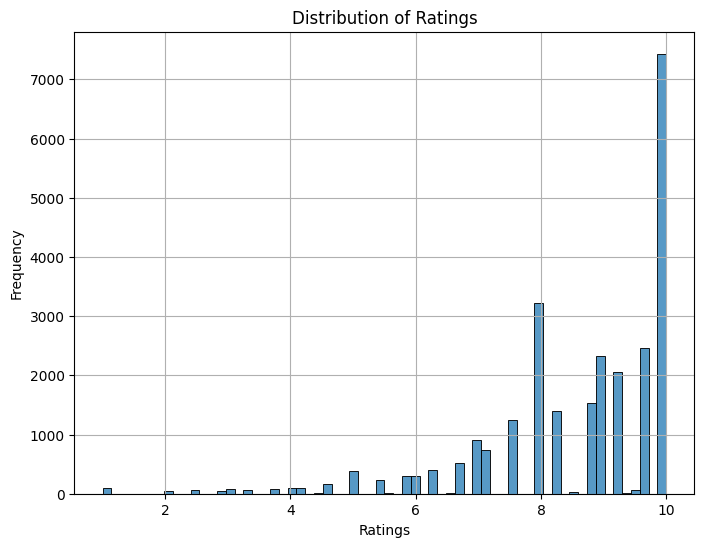

In [ ]:
# Plotting distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], kde=False)
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The above histogram shows that a lot of ratings in the dataset are usually on the high end. This may follow a general trend where users of a system tend to only rate items they like and ignore those they don't. The ratings also fall in the 0 - 10 range.

Next a wordcloud is generated to have a fair idea of the most common terms used in the reviews.

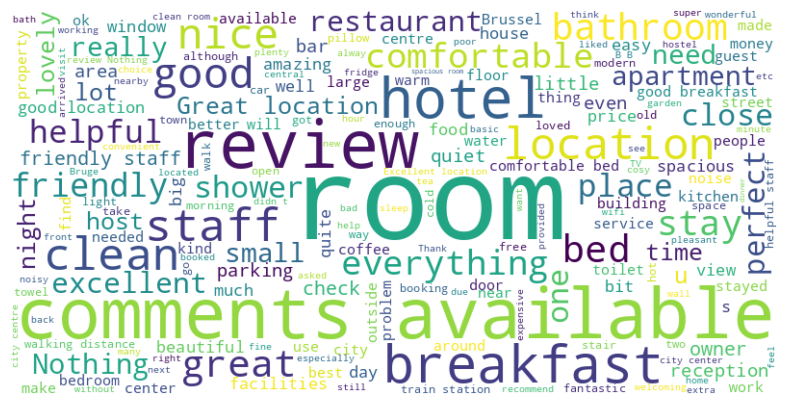

In [ ]:
# Filter out rows with missing text data
df = df.dropna(subset = ['review_text'])

# Concatenate text from all rows into a single string
text = " ".join(df['review_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The world cloud shows words such as hotel, room, breakfast etc. that we will generally expect in this domain.

The dataframe is then converted spark dataframe which will aid in easing required computations.

In [ ]:
# Converting pandas dataframe into spark dataframe
bookings = spark.createDataFrame(df)

# Show the first few rows of the Spark DataFrame
bookings.show()

+--------------------+----------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------+------+--------------------+--------------------+--------------------+--------------------+
|        review_title|     reviewed_at| reviewed_by|              images|          crawled_at|                 url|          hotel_name|           hotel_url|avg_rating|   nationality|rating|         review_text|     raw_review_text|                tags|                meta|
+--------------------+----------------+------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------+------+--------------------+--------------------+--------------------+--------------------+
|         Exceptional|    11 July 2021|      Kyrylo|                 NaN|07/20/2021, 01:09:27|https://www.booki...|     Villa Pura Vida|https://www.booki...|       9.7|       

In [ ]:
# Printing the schema of the dataframe
bookings.printSchema()

root
 |-- review_title: string (nullable = true)
 |-- reviewed_at: string (nullable = true)
 |-- reviewed_by: string (nullable = true)
 |-- images: string (nullable = true)
 |-- crawled_at: string (nullable = true)
 |-- url: string (nullable = true)
 |-- hotel_name: string (nullable = true)
 |-- hotel_url: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- nationality: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- review_text: string (nullable = true)
 |-- raw_review_text: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- meta: string (nullable = true)



As indicated before, I plan to analyze the relationship between hotel ratings and the content of the reviews provided by guests. This will involve text analysis techniques to extract meaningful information from the review text and build a predictive model to estimate hotel ratings based on this information. The selcted columns (review_title, nationality, review_text) that wil be used for this are shown below. I believe that these columns contain the best combination of keywords to give the best descriptions.

In [ ]:
# Selecting relevant features

clean_bookings = bookings.select("review_title", "nationality", "review_text", "rating")

clean_bookings.show()

+--------------------+--------------+--------------------+------+
|        review_title|   nationality|         review_text|rating|
+--------------------+--------------+--------------------+------+
|         Exceptional|        Poland|Everything was pe...|  10.0|
|I highly recommen...|       Belgium|Very friendly hos...|   9.0|
|         Exceptional|United Kingdom|It was just what ...|  10.0|
|My stay in the ho...|   Netherlands|My stay in the ho...|  10.0|
|One bedroom apart...|  South Africa|The building itse...|   9.2|
|Fantastic! Beauti...|United Kingdom|Nothing,\n\nBeaut...|  10.0|
|everything perfec...|        Poland|to many messages ...|  10.0|
|           Very good|   Netherlands|Spacious, more th...|   8.3|
|              Superb|United Kingdom|There are no comm...|   9.2|
|  highly recommended| United States|nothing -- place ...|  10.0|
|Super romantic ve...|       Belgium|Romantic room jus...|  10.0|
|         Exceptional|United Kingdom|Nothing,\n\nEvery...|  10.0|
|         

# Section 2: Data Cleaning

I will now proceed to clean the dataset by:

- Concatenating relevant columns into a single column for text analysis.
- Converting text to lowercase for uniformity.

In [ ]:
# Concatenating text columns

clean_bookings_merged = clean_bookings.withColumn(
    "review_doc",
    concat_ws(" ", clean_bookings["review_title"], clean_bookings["nationality"], clean_bookings["review_text"])
)

clean_bookings_merged = clean_bookings_merged.drop("review_title", "nationality", "review_text")

clean_bookings_merged.show()

+------+--------------------+
|rating|          review_doc|
+------+--------------------+
|  10.0|Exceptional Polan...|
|   9.0|I highly recommen...|
|  10.0|Exceptional Unite...|
|  10.0|My stay in the ho...|
|   9.2|One bedroom apart...|
|  10.0|Fantastic! Beauti...|
|  10.0|everything perfec...|
|   8.3|Very good Netherl...|
|   9.2|Superb United Kin...|
|  10.0|highly recommende...|
|  10.0|Super romantic ve...|
|  10.0|Exceptional Unite...|
|   7.5|Good United Kingd...|
|   8.0|Very good Netherl...|
|   9.0|Superb Sweden The...|
|  10.0|Exceptional Austr...|
|   9.6|Excellent United ...|
|  10.0|Exceptional Nethe...|
|  10.0|Lovely break in a...|
|   9.0|Christmas stay Be...|
+------+--------------------+
only showing top 20 rows



In [ ]:
# Lower casing review_text column

clean_bookings_lower = clean_bookings_merged.withColumn("review_doc_lower", lower(clean_bookings_merged["review_doc"]))
clean_bookings_lower = clean_bookings_lower.drop("review_doc")  # Optional: Drop the original column if not needed
clean_bookings_lower.show()

+------+--------------------+
|rating|    review_doc_lower|
+------+--------------------+
|  10.0|exceptional polan...|
|   9.0|i highly recommen...|
|  10.0|exceptional unite...|
|  10.0|my stay in the ho...|
|   9.2|one bedroom apart...|
|  10.0|fantastic! beauti...|
|  10.0|everything perfec...|
|   8.3|very good netherl...|
|   9.2|superb united kin...|
|  10.0|highly recommende...|
|  10.0|super romantic ve...|
|  10.0|exceptional unite...|
|   7.5|good united kingd...|
|   8.0|very good netherl...|
|   9.0|superb sweden the...|
|  10.0|exceptional austr...|
|   9.6|excellent united ...|
|  10.0|exceptional nethe...|
|  10.0|lovely break in a...|
|   9.0|christmas stay be...|
+------+--------------------+
only showing top 20 rows



I will also create a unique id for each review to uniquely identify each row

In [ ]:
# Setting ID by the row number of each entry of the table
clean_bookings_lower.createOrReplaceTempView('bookings')

# Create the sequential integer id value for each PageName
review_id = spark.sql('select row_number() over (order by "Review") as ID, * from bookings')

# Show 20 Rows
review_id.show(20)

+---+------+--------------------+
| ID|rating|    review_doc_lower|
+---+------+--------------------+
|  1|  10.0|exceptional polan...|
|  2|   9.0|i highly recommen...|
|  3|  10.0|exceptional unite...|
|  4|  10.0|my stay in the ho...|
|  5|   9.2|one bedroom apart...|
|  6|  10.0|fantastic! beauti...|
|  7|  10.0|everything perfec...|
|  8|   8.3|very good netherl...|
|  9|   9.2|superb united kin...|
| 10|  10.0|highly recommende...|
| 11|  10.0|super romantic ve...|
| 12|  10.0|exceptional unite...|
| 13|   7.5|good united kingd...|
| 14|   8.0|very good netherl...|
| 15|   9.0|superb sweden the...|
| 16|  10.0|exceptional austr...|
| 17|   9.6|excellent united ...|
| 18|  10.0|exceptional nethe...|
| 19|  10.0|lovely break in a...|
| 20|   9.0|christmas stay be...|
+---+------+--------------------+
only showing top 20 rows



# Section 3: Transforming the Clean Data

Here, I will transform the clean data by tokenizing the text and converting it into numerical features suitable for machine learning algorithms.

In [ ]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Define regex tokenizer to tokenize words and remove punctuations
tokenizer = RegexTokenizer(inputCol="review_doc_lower", outputCol="words", pattern=r"\W")

# Define count vectorizer to count token occurrences and limit vocabulary size
vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=1000000)

# Define pipeline to tokenize, vectorize, and transform data
pipeline = Pipeline(stages=[tokenizer, vectorizer])

# Fit and transform the data
pipeline_model = pipeline.fit(review_id)
final_df = pipeline_model.transform(review_id).select("ID", "words", "features", "rating")

# Show the resulting dataframe
final_df.show()

+---+--------------------+--------------------+------+
| ID|               words|            features|rating|
+---+--------------------+--------------------+------+
|  1|[exceptional, pol...|(16182,[2,4,28,49...|  10.0|
|  2|[i, highly, recom...|(16182,[1,3,6,11,...|   9.0|
|  3|[exceptional, uni...|(16182,[0,1,2,3,5...|  10.0|
|  4|[my, stay, in, th...|(16182,[0,1,2,3,7...|  10.0|
|  5|[one, bedroom, ap...|(16182,[0,1,2,3,4...|   9.2|
|  6|[fantastic, beaut...|(16182,[0,1,3,4,5...|  10.0|
|  7|[everything, perf...|(16182,[0,4,6,7,1...|  10.0|
|  8|[very, good, neth...|(16182,[0,3,5,6,7...|   8.3|
|  9|[superb, united, ...|(16182,[5,9,10,11...|   9.2|
| 10|[highly, recommen...|(16182,[0,1,2,4,8...|  10.0|
| 11|[super, romantic,...|(16182,[0,1,3,7,1...|  10.0|
| 12|[exceptional, uni...|(16182,[0,3,4,5,1...|  10.0|
| 13|[good, united, ki...|(16182,[0,1,3,4,7...|   7.5|
| 14|[very, good, neth...|(16182,[0,3,6,8,1...|   8.0|
| 15|[superb, sweden, ...|(16182,[0,5,25,26...|   9.0|
| 16|[exce

I follow that up by splitting the data into training and test sets for model evaluation.

In [ ]:
# Split the data into training and test sets
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=123)

# Section 4: Model Development and Evaluation

For my model, I will train a linear regression model to predict hotel ratings based on the text features extracted from the reviews. This model will then be evaluated using the RMSE metric to view the error between actual and predicted ratings.

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expr

# Define the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="rating")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Ensure predictions are within the range [0, 10] and rounded to one decimal place
predictions = predictions.withColumn("prediction", expr("ROUND(CASE WHEN prediction < 0 THEN 0 WHEN prediction > 10 THEN 10 ELSE prediction END, 1)"))

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.63606


The RMSE value of 1.64 on the test data indicates that, on average, the predictions made by the model are off by approximately 1.64 units from the actual values. This shows that the model performs moderately based on current parameters.

Future work will include alternative feature selection and engineering methods in addition to testing on different models to potentially obtain better performance on predictions.